In [2]:
"""
Study Material:
    https://www.kaggle.com/code/ryanholbrook/trend
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# print(tf.__version__)

import os
import logging
import pandas as pd
import seaborn as sns
from datetime import datetime, date 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from dateutil.relativedelta import relativedelta


import pickle
logging.basicConfig(filename="temp.log", filemode = "w", level=logging.INFO) # add filemode="w" to overwrite
from dataPull import getYfinData as getYfinData

""" References
https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide

"""

' References\nhttps://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide\n\n'

In [70]:
# Data Pull
dataPullCfg = True
vpnFlg = True

myTicker = 'QQQ'
tickerLst = ['XPO', 'BABA', 'NVDA', 'QQQ', 'ENPH']
# requestThd = 5
dateFilt = '2021-8-15'
# getData(tickerLst, requestThd, dateFilt) # Alpha Vantage

if not vpnFlg:
    os.environ['http_proxy'] = ''
    os.environ['https_proxy'] = ''
else:
    print('Enter at a later time!')

if dataPullCfg:
    getYfinData(tickerLst, None)

# -------------------------------------------------------------------- #
# Load Data from Disk
dir = os.getcwd()
dir = dir + "\\" + "stockData.file"
with open(dir, "rb") as f:
    dump = pickle.load(f)
    print("deserialization of " + dir + " complete...")
assert len(dump) > 0, 'Check Data Pull'

Enter at a later time!
deserialization of c:\Users\malikf1\Desktop\DataScience\Local_Development\Personal_Projects\MLStockForecast\stockData.file complete...


In [263]:
dateFilter = '2000-01-01'
stockDataFrame = dump[myTicker].copy()
# Resample Data at a Monthly Level
stockDataFrame = stockDataFrame[['date',
                 'open', 
                 'high',
                 'low', 
                 'close',
                 'volume',
                 'dividends',
                 'stock_splits',
                 'symbol',
                 'load_date'
                ]].resample('M', on='date').mean().reset_index(drop=False)
stockDataFrame = stockDataFrame.set_index('date')
stockDataFrame['time'] = np.arange(len(stockDataFrame.index)) # The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.
stockDataFrame = stockDataFrame[stockDataFrame.index > dateFilter]

Text(0.5, 1.0, 'QQQ')

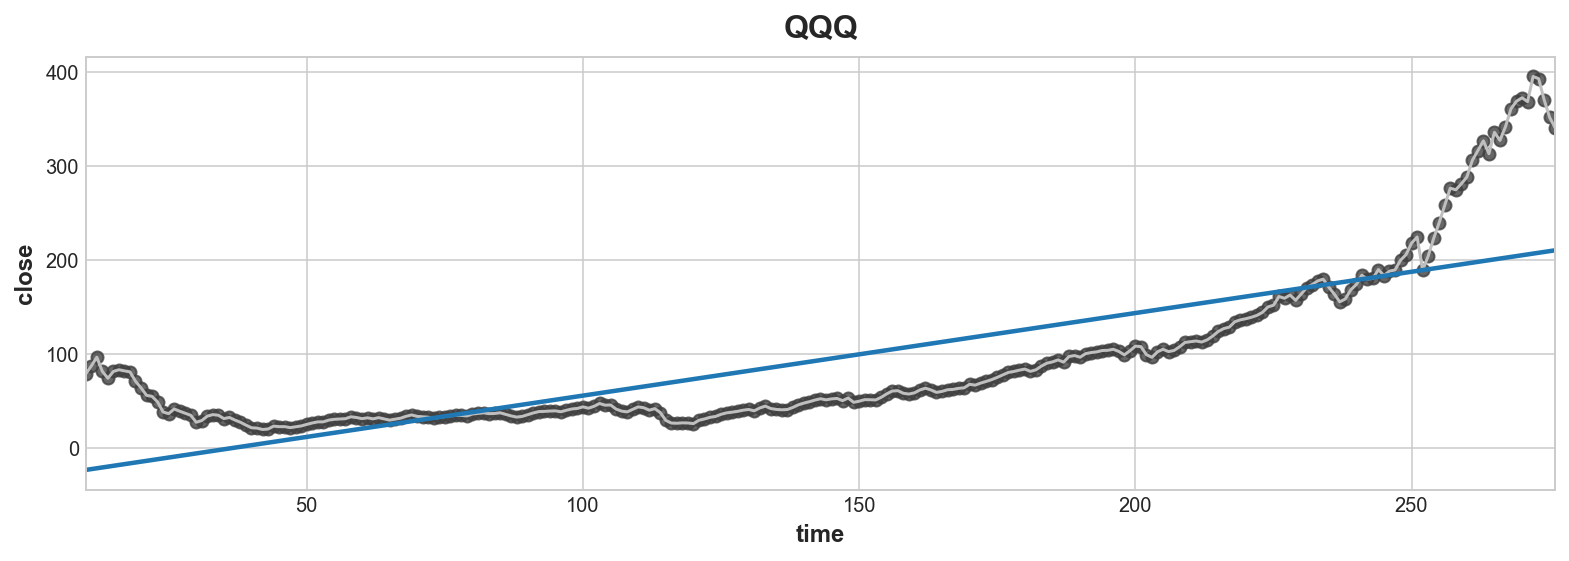

In [264]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('time', 'close', data=stockDataFrame, color='0.75')
ax = sns.regplot(x='time', y='close', data=stockDataFrame, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title(myTicker)

In [265]:
stockDataFrame['lag_1'] = stockDataFrame['close'].shift(1)
# stockDataFrame = stockDataFrame.reindex(columns=['close', 'lag_1', 'time'])

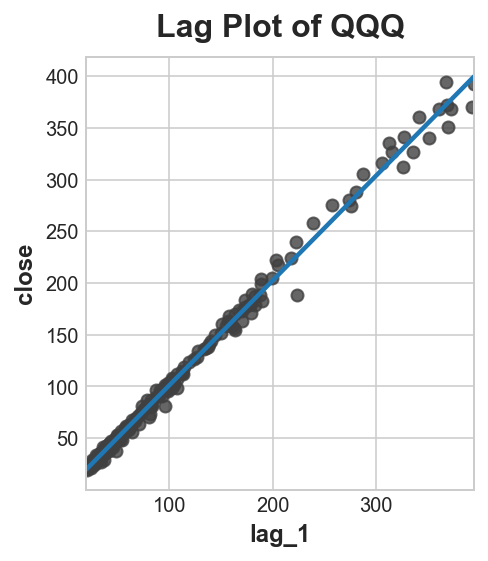

In [267]:
# Plot against Lag
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='close', data=stockDataFrame, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of ' + myTicker);

### Forecast

In [ ]:
from sklearn.linear_model import LinearRegression
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells

In [268]:
# Training data
X = stockDataFrame.loc[:, ['time']]  # features
y = stockDataFrame.loc[:, 'close']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


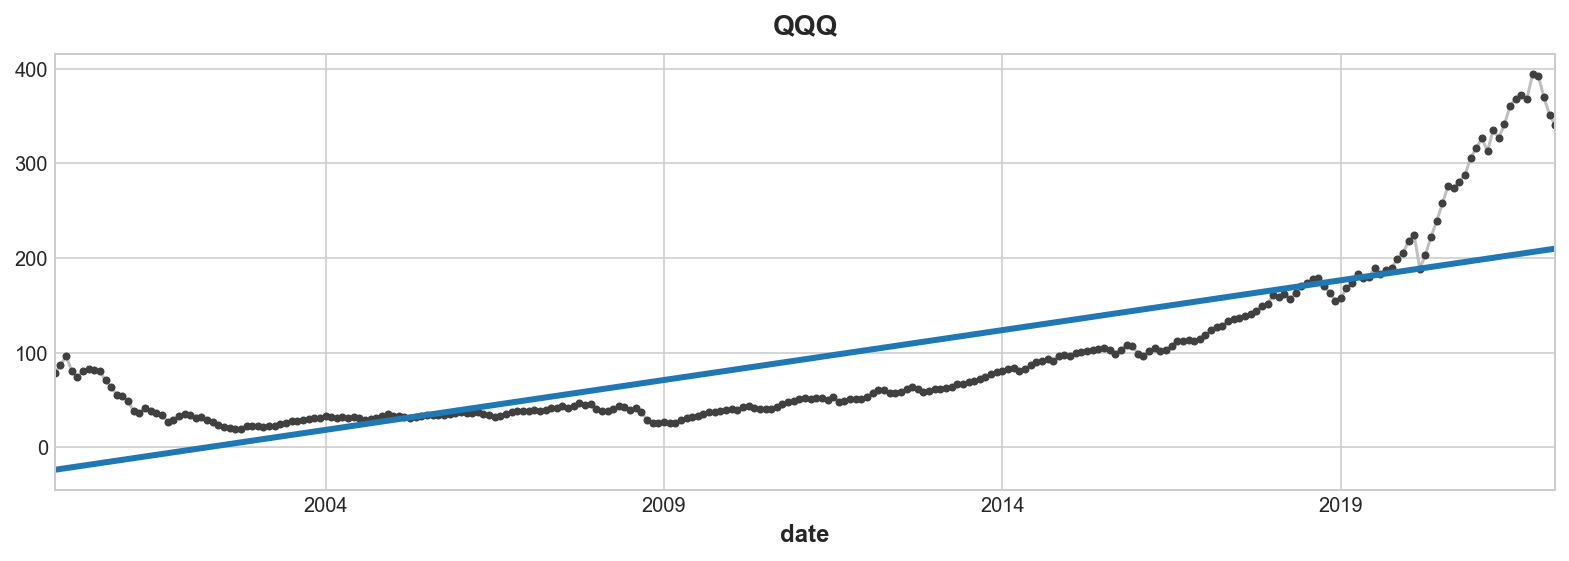

In [270]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title(myTicker);

In [271]:
# Create Model with Lagged Training Data
X = stockDataFrame.loc[:, ['lag_1']]
X.dropna(inplace=True) 
y = stockDataFrame.loc[:, 'close']  # create the target
y, X = y.align(X, join='inner') # Align with dates

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

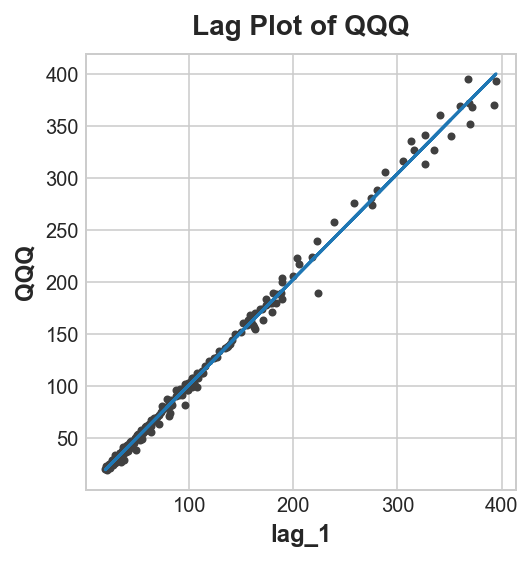

In [273]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel(myTicker)
ax.set_xlabel('lag_1')
ax.set_title('Lag Plot of ' + myTicker);

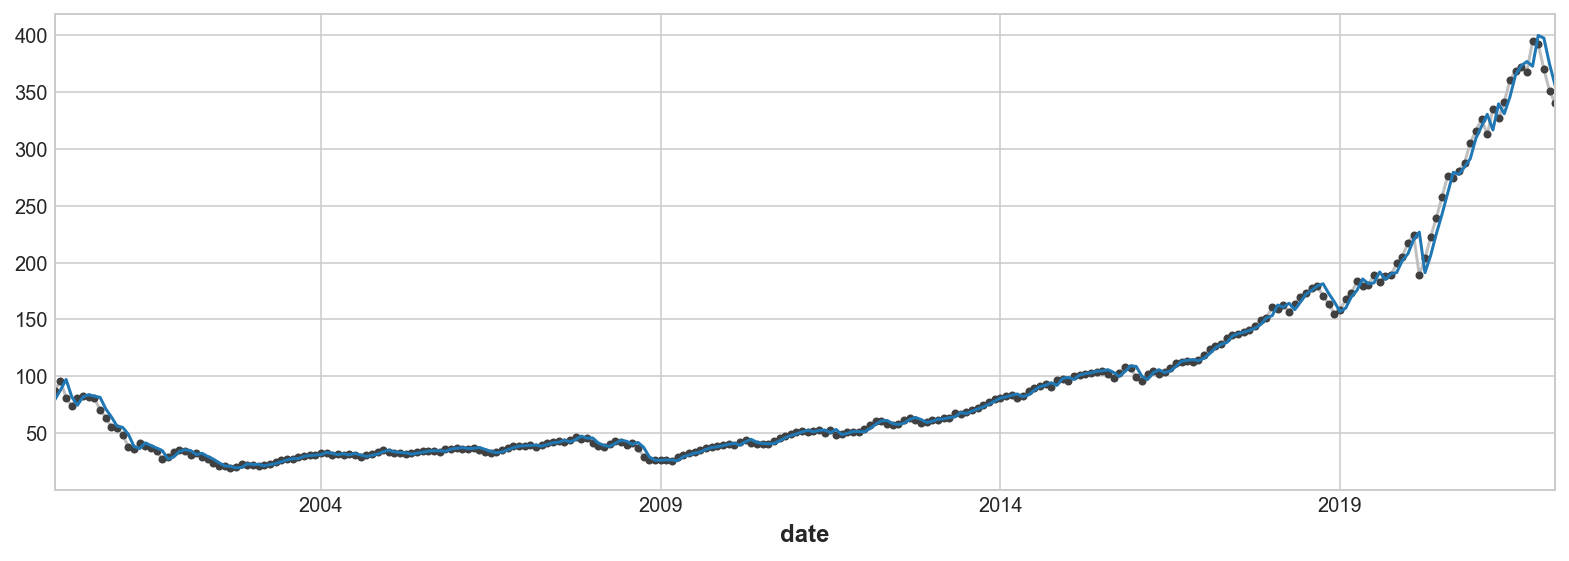

In [274]:
ax = y.plot(**plot_params)
ax = y_pred.plot() # Training w/ Lag of Closing Price

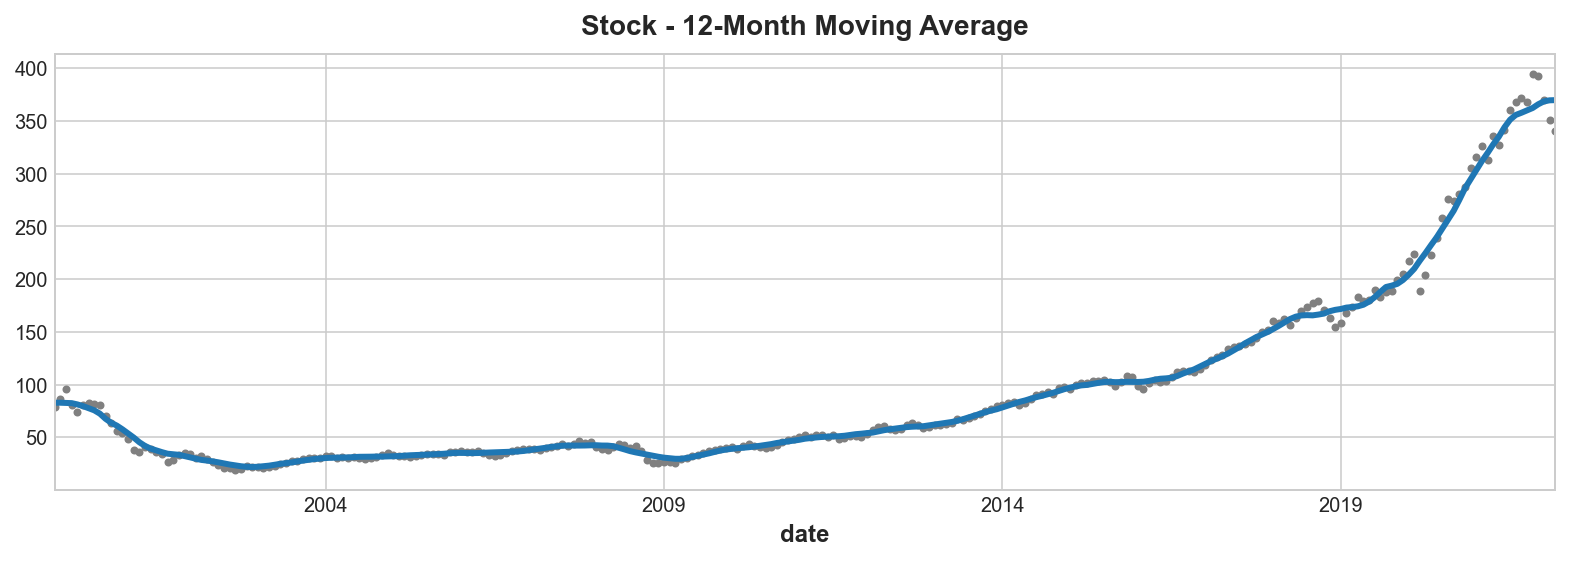

In [275]:
# Create Moving Average
moving_average = stockDataFrame['close'].rolling(
    window=12,       # 12-month window since monthly observations
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = stockDataFrame['close'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Stock - 12-Month Moving Average", legend=False,
);

In [299]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=stockDataFrame.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X

,const,trend,trend_squared,trend_cubed
date,,,,
2000-01-31,1.0,1.0,1.0,1.0
2000-02-29,1.0,2.0,4.0,8.0
2000-03-31,1.0,3.0,9.0,27.0
2000-04-30,1.0,4.0,16.0,64.0
2000-05-31,1.0,5.0,25.0,125.0
...,...,...,...,...
2021-11-30,1.0,263.0,69169.0,18191447.0
2021-12-31,1.0,264.0,69696.0,18399744.0
2022-01-31,1.0,265.0,70225.0,18609625.0


In [304]:
# Use Deterministic Data for Training 
y = stockDataFrame["close"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

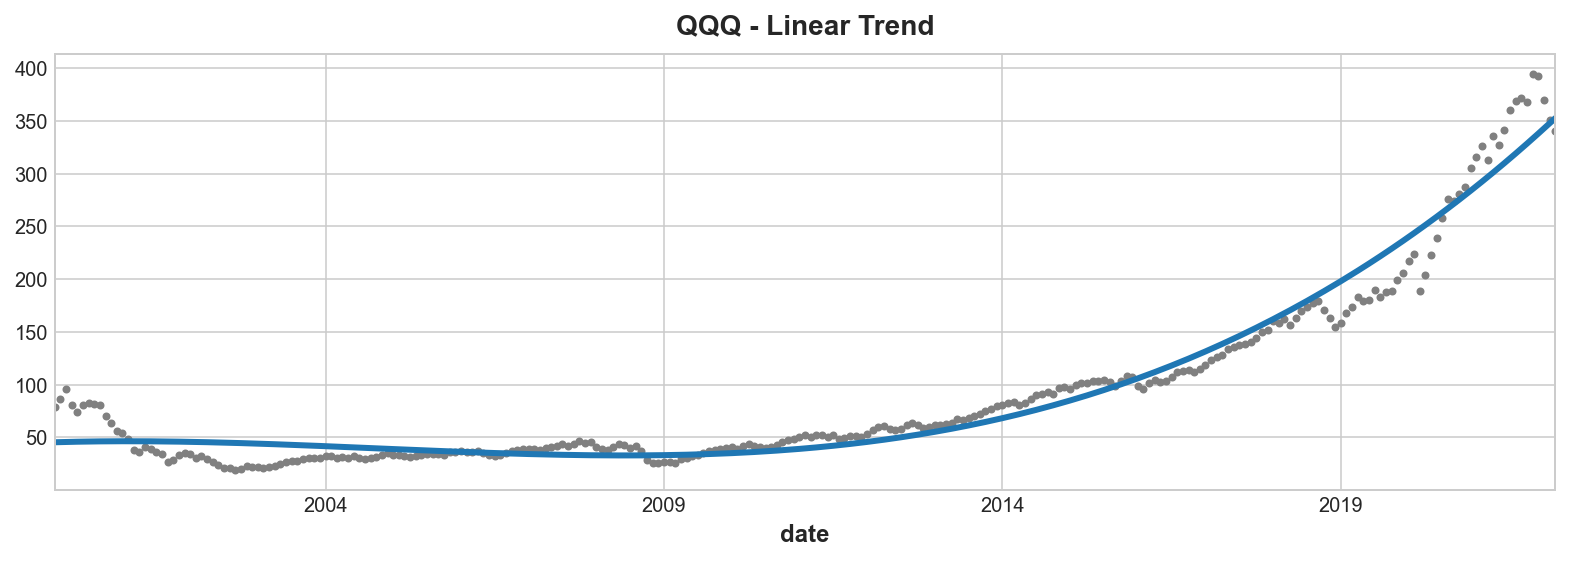

In [305]:
ax = stockDataFrame['close'].plot(style=".", color="0.5", title= myTicker + " - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [306]:
mySteps = 24
futureDateLst = []
# Derive Future Dates
for i in range(1, mySteps + 1):
    futureDateLst.append(stockDataFrame.index[-1] + relativedelta(months=+i))

X= dp.out_of_sample(steps= mySteps)
X.index = futureDateLst
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-04-30    357.478371
2022-05-31    362.503967
2022-06-30    367.579609
2022-07-31    372.705535
2022-08-31    377.881980
dtype: float64

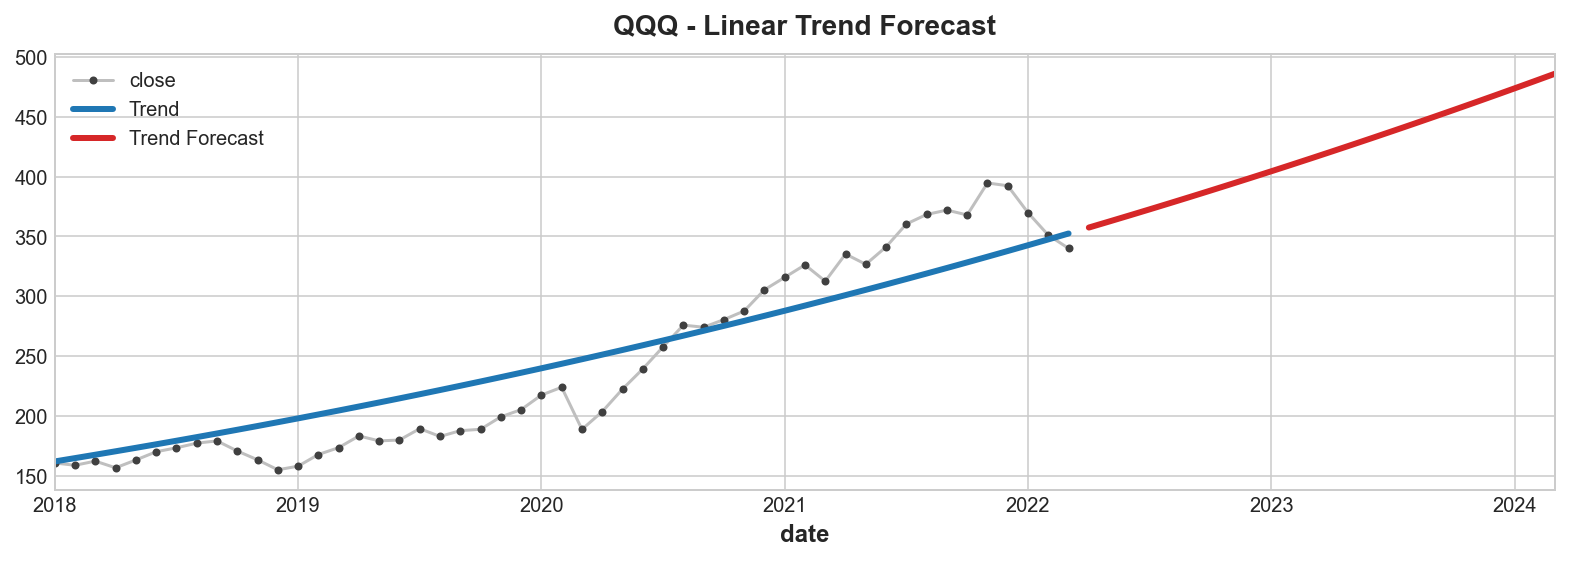

In [307]:
ax = stockDataFrame["2018-01-31":]['close'].plot(title= myTicker + " - Linear Trend Forecast", **plot_params)
ax = y_pred["2018-01-31":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()